# Mocap Initial Modelling

* Deterministic LDS
* Not doing delta: error accumulation is bad

In [1]:
# using Revise
using LinearAlgebra, Random
using StatsBase, Statistics
using Distributions, MultivariateStats   # Categorical, P(P)CA
using Quaternions    # For manipulating 3D Geometry
using MeshCat        # For web visualisation / animation
using PyPlot         # Plotting
using AxUtil         # Cayley, skew matrices
using Flux           # Optimisation
using DSP            # convolution / low-pass (MA) filter

# small utils libraries
using ProgressMeter, Formatting, ArgCheck
using DelimitedFiles, NPZ, BSON

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-9562964168488566578\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14073764840603512276\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/5794a0bf2e6325e42dc09c7369026176a04edd3e-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-9562964168488566578\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/AxUtil/zkGYv.ji for AxUtil [739e4dca-d06b-11e8-2625-cffd46b96d05]
└ @ Base loading.jl:1184
┌ Warning: Package AxUtil does not have ArgCheck in its dependencies:
│ - If you have AxUtil checked out for development and have
│   added ArgCheck as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with AxUtil
└ Loading ArgCheck into AxUtil from project dependency, future warnings for AxUtil are suppressed.


In [2]:
function zero_grad!(P) 
    for x in P
        x.grad .= 0
    end
end

zero_grad! (generic function with 1 method)

In [3]:
DIR_MOCAP_MTDS = "." 

# Data loading and transformation utils
include(joinpath(DIR_MOCAP_MTDS, "io.jl"))

# MeshCat skeleton visualisation tools
include(joinpath(DIR_MOCAP_MTDS, "mocap_viz.jl"))

# Data scaling utils
include(joinpath(DIR_MOCAP_MTDS, "util.jl"))
import .mocaputil: MyStandardScaler, scale_transform, invert
import .mocaputil: OutputDifferencer, difference_transform, fit_transform
import .mocaputil: no_pos, no_poscp

# Models: LDS
include(joinpath(DIR_MOCAP_MTDS, "models.jl"))
import .model: Astable

Main.model

### Load in Data
See `2_Preprocess.ipynb`

**Note that in the current harddisk state, `edin_Ys.bson` was created with `include_ftcontact=false`**


### Additional changes since `2_Preprocess`:

1. Performing a difference transform of joint positions in $Y$. Motivated by trivial predictions of copying previous frame working too well. I want to force the model to learn something.
2. Remove joint positions entirely from inputs:
    * Don't want prev positions for regression to output ($D$ matrix) as predicting a copy reduces the error close to zero, and makes it difficult to understand which model is performing best for the remaining delta.
    * Also don't want in latent state, as positions have already been projected to the latent state (a linear comb) => hence colinear.


In [4]:
database = "../data/mocap/edin-style-transfer/"
files_edin = [joinpath(database, f) for f in readdir(database)];
style_name_edin = [x[1] for x in match.(r"\.\./[a-z\-]+/[a-z\-]+/[a-z\-]+/([a-z]+)_.*", files_edin)];
styles = unique(style_name_edin)
styles_lkp = [findall(s .== style_name_edin) for s in styles];

In [5]:
Usraw = BSON.load("edin_Xs.bson")[:Xs];
Ysraw = BSON.load("edin_Ys.bson")[:Ys];

standardize_Y = fit(MyStandardScaler, reduce(vcat, Ysraw),  1)
standardize_U = fit(MyStandardScaler, reduce(vcat, Usraw),  1)

Ys = [scale_transform(standardize_Y, y[2:end, :] ) for y in Ysraw];
Us = [scale_transform(standardize_U, u[1:end-1,:]) for u in Usraw];  # remove first frame too

In [6]:
invert_output_tform(y, i) = invert(standardize_Y, y) |> yhat -> invert(dtforms[i], yhat)

invert_output_tform (generic function with 1 method)

we can reconstruct the original data via the commands:

    invert_output_tform(y, i)       # for (i,y) in enumerate(Ys)
    invert(standardize_X, x)        # for x in Xs
    
in the relevant array comprehensions.

In [7]:
?mocapio.construct_inputs

```
construct_inputs(raw [; direction=:relative, joint_pos=true])
```

Construct the input matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to construct trajectories that extend ± 60 frames of the current position. (The additional is due to needing a bit extra to calculate velocity, plus some historical baggage.) Note also that the trajectory is centered at every frame at the current position and hence `(trajectory_x(7), trajectory_z(7)) == (0.0, 0.0)`.

The following columns are contained in the matrix:

  * (12): ± 60 frame trajectory x-cood at step 10 intervals
  * (12): ± 60 frame trajectory z-cood at step 10 intervals
  * (12): ± 60 frame trajectory angle sin(θ) to forward
  * (12): ± 60 frame trajectory angle cos(θ) to forward
  * (12): ± 60 frame trajectory magnitude of velocity
  * (61): joint positions in Lagrangian frame (optional)

The angle θ is expressed in both sine and cosine components to avoid a discontinuity when it wraps around 2π (which it sometimes does). This angle is Lagrangian in nature too: that is, θ = 0 when the skeleton is facing in exactly the same direction as it is walking (i.e. the direction of the velocity). One might prefer a Eulerian (absolute) representation instead, in which case, pass in the named argument `direction=:absolute`.

Note that there are only 61 dimensions of the joint positions as the root x,z are excluded, as they are always zero. They're excluded from the output too, which is more important: we don't want to waste strength on predicting zero. In most of my experiments, I have found that including the joint positions in the input tends to make it too easy for the model to obtain trivial predictions. To avoid returning any joint_positions in the input matrix, select:

```
joint_pos=false
```


In [8]:
?mocapio.construct_outputs

```
construct_outputs(raw [; include_ftcontact])
```

Construct the output matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to match with the input matrix which needs these boundaries in order to construct trajectories consistently. This function outputs a matrix with the following columns:

  * (3): rotational velocity, x-velocity, z-velocity
  * (61): (Lagrangian) joint positions (excl. root x/z ∵ always zero)
  * (4): [optional] feet contacts

These are the minimal requirements to reconstruct an animation of human motion on the target skeleton. The feet contacts are in {0,1} and may be challenging for some linear models, therefore they are optional (see named argument     `include_ftcontact` (Bool)).


In [102]:
# MAT.matwrite("angry1_UY.mat", Dict("cYs"=>cYs, "cUT"=>cUT, "version"=>"may23_1809"))

# Initialise LDS

## Understand PC distribution

#### Single-task Model

In [ ]:
fig, axs = subplots(4,2,figsize=(5.5,6))

for (i, ixs) in enumerate(styles_lkp)
    cYs = reduce(vcat, Ys[ixs])
    pc_all = fit(PCA, cYs[:,4:63]', pratio=0.999)

    varexpl = cumsum(principalvars(pc_all))/tvar(pc_all)
    bd=findfirst.([varexpl .> x for x in [0.9,0.95,0.99]])
    axs[:][i].plot(1:length(varexpl), varexpl)
    axs[:][i].axhline(1, linestyle=":")
    for b in bd
        axs[:][i].plot([b,b], [varexpl[1], varexpl[b]], color=ColorMap("tab10")(7), linestyle=":")
        axs[:][i].plot([.5, b], [varexpl[b], varexpl[b]], color=ColorMap("tab10")(7), linestyle=":")
        axs[:][i].text(b+0.3,varexpl[1]+0.03, b)
    end
    axs[:][i].set_xlim(0.5,34.5); gca().set_ylim(varexpl[1],1.025);
    axs[:][i].xaxis.set_ticklabels([])
    axs[:][i].set_title(styles[i])
end
tight_layout()

#### Pooled Model

In [ ]:
allE = reduce(vcat, Ys);
allE = convert(Matrix{Float32}, allE);

pc_all = fit(PCA, allE[:,4:63]', pratio=0.999)

varexpl = cumsum(principalvars(pc_all))/tvar(pc_all)
bd=findfirst.([varexpl .> x for x in [0.9,0.95,0.99]])
plot(1:length(varexpl), varexpl)
gca().axhline(1, linestyle=":")
for b in bd
    plot([b,b], [varexpl[1], varexpl[b]], color=ColorMap("tab10")(7), linestyle=":")
    plot([.5, b], [varexpl[b], varexpl[b]], color=ColorMap("tab10")(7), linestyle=":")
    text(b+0.3,varexpl[1]+0.03, b)
end
gca().set_xlim(0.5,37.5); gca().set_ylim(varexpl[1],1.025);
gcf().set_size_inches(3,2)

## LDS Initialisation

\begin{align}
\mathbf{x}_t &= A \mathbf{x}_{t-1} + B \mathbf{u}_t + \mathbf{b}\\
\mathbf{y}_t &= C \mathbf{x}_{t} + D \mathbf{u}_t + \mathbf{d}
\end{align}

#### Initialisation

Note in the below I use the SVD construction for PCA for convenience, but in general $Y$ is not centered ($\because$ centering is done over \emph{all} styles simultaneously; each individual will not be centered). Therefore, the below assumes this centering is done temporarily before the SVD.

* $C = U_{SVD}$, where $U_{SVD}$ are the prinicipal components of $Y$.
* $X = S_{SVD}V_{SVD}^{\mathsf{T}}$, where $S_{SVD}$, $V_{SVD}$ are the other matrices from the SVD.
* $X \approx \tilde{U}\tilde{B} \Rightarrow \tilde{B} = (\tilde{U}^{\mathsf{T}} \tilde{U})^{-1} \tilde{U}^{\mathsf{T}} X$ (Regression of $X$ on $U$). The permutation of $U$ and $B$ in the first equation follows because the obs are column-wise here, not row-wise.
    * Here, $\tilde{U} = \begin{bmatrix} U & \mathbf{1} \end{bmatrix}$, and hence $\tilde{B} = \begin{bmatrix} B & \mathbf{b} \end{bmatrix}$

## Single task LDS

In [ ]:
include(joinpath(DIR_MOCAP_MTDS, "models.jl"))

In [ ]:
style_ix = 1
cYs = Matrix(transpose(reduce(vcat, Ys[styles_lkp[style_ix]])))
cUs = reduce(vcat, Us[styles_lkp[style_ix]])
cUT = Matrix(cUs');
cN = size(cYs, 2)

In [137]:
rmse(Δ,scale=size(Δ, 1)) = sqrt(mean(x->x^2, Δ))*scale

rmse (generic function with 2 methods)

In [ ]:
let tmp = mapslices(z->sqrt(mean(x->x^2, z)), cYs - CDd * [cUT; ones(1, cN)], dims=1)[1:1000]
    tmpr1 = mapslices(z->sqrt(mean(x->x^2, z)), cYs[:,1:1000] - clds(cUT[:,1:1000]), dims=1)[1:1000]
    plot(conv(tmp, Windows.rect(30))[:31:end-30])
    plot(conv(f64(tmpr1), Windows.rect(30))[:31:end-30])
end
title("error over time")

In [527]:
# Simple baselines
baselines = Dict()
baselines["copy"] = rmse(cYs[:,2:end] - cYs[:,1:end-1])

# cUs_m1 = cUs[1:end-1,:];
CDd = cYs / [cUT; ones(1, cN)]
baselines["LR"] = rmse(cYs[:,:] - CDd * [cUT; ones(1, cN)])

6.854500332774838

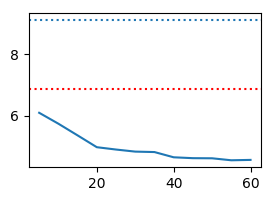

PyObject <matplotlib.lines.Line2D object at 0xb6ba27d30>

In [525]:
plot(5:5:60, perf_init); gcf().set_size_inches(3,2)
gca().axhline(baselines["copy"], linestyle=":")
gca().axhline(baselines["LR"], linestyle=":", color="red")

In [534]:
clds = model.init_LDS_spectral(cYs, cUT, 10; max_iter=4)

Main.model.MyLDS_ng{Float32}(Float32[3.8002, 0.389062, 0.0452926, 0.0341374, 0.00374353, 0.00250781, 0.00154656, 0.001, 0.001, 0.001  …  -4.71617, 1.05452, 0.251247, 0.000427542, 0.454889, -2.4878, -0.000424572, 1.46011, 0.000688339, 0.000637486], Float32[-0.0191449 0.0198947 … -0.00396444 0.119779; -0.00138662 0.00332535 … -0.0198716 -0.0144564; … ; -0.00270047 -0.000608933 … 0.0362085 -0.0163498; -1.4232e-6 2.65874e-7 … 1.24714e-5 -6.25957e-6], Float32[-0.00854589, -0.0564871, 0.0256376, -0.00869265, -0.153117, -0.127148, -0.053295, -0.00392294, 0.0533211, 1.11908e-5], Float32[-1.02193 -3.71257 … 92547.3 -3.91284e8; 3.04563 36.8813 … -55033.9 2.22828e8; … ; 3.19207 -2.71468 … -39539.1 1.6707e8; 3.62294 -7.54603 … -44795.9 2.07351e8], Float32[-320.836 168.557 … 1478.55 -919.128; 134.887 -53.0324 … -1050.97 652.484; … ; 134.712 -70.5142 … -629.485 395.485; 190.945 -102.905 … -987.356 585.452], Float32[-212.719, 109.264, -192.882, 210.752, 210.389, 230.412, -433.025, -2.69199, -306.827,

In [ ]:
imshow(clds.C[:,1:2]'); gca().set_aspect("auto")

In [ ]:
imshow(clds.B[2:2,1:50]); gca().set_aspect("auto")

In [ ]:
imshow(CDd[4:end,1:50])

In [523]:
perf_init = [rmse(model.init_LDS_spectral(cYs, cUT, k)(cUT) - cYs) for k in 5:5:60];

In [619]:
perf_init

12-element Array{Float32,1}:
 6.0907803
 5.7354817
 5.355541 
 4.9713855
 4.8953323
 4.827998 
 4.8135757
 4.643134 
 4.6147943
 4.610619 
 4.5461884
 4.5584083

In [610]:
clds_orig = model.init_LDS_spectral(cYs, cUT, 10; max_iter=1);

In [613]:
k = 10
    
# clds_g = model.make_grad(model.init_LDS_spectral(cYs, cUT, k))
clds_g = model.make_grad(clds_orig)
clds   = model.make_nograd(clds_g)   # MUST DO THIS SECOND, (Flux.param takes copy)

opt = ADAM(1e-4)
opt_hidden = ADAM(0.7e-5)

ADAM(7.0e-6, (0.9, 0.999), IdDict{Any,Any}())

In [614]:
opt_hidden = ADAM(0.7e-5)
ps_hidden = Flux.params(clds_g.a, clds_g.B, clds_g.b)
ps_observ = Flux.params(clds_g.C, clds_g.D, clds_g.d)

Params([Float32[-0.00207143 0.0845 … -330.777 -526.703; 0.000288 -0.38952 … 11209.5 -3803.68; … ; 2.6701e-6 -0.0518064 … 228.45 -313.403; -4.63683e-5 0.0656844 … 2807.39 5218.72] (tracked), Float32[1.95866 -6.62981 … 25.5651 -4.49161; -50.0777 46.4598 … -183.984 109.881; … ; -4.80827 4.59732 … 13.4358 -4.26586; 2.84887 13.0085 … -261.895 109.34] (tracked), Float32[190.303, -229.677, 238.162, 58.2152, 136.342, 69.6699, -264.451, 101.951, -241.31, -165.964  …  9.54691, 182.935, 31.1078, -103.743, 153.228, 42.8481, -199.348, 134.233, 44.0946, -212.379] (tracked)])

In [618]:
rmse(clds(cUT) - cYs)

5.7977905f0

In [617]:
@time h = begin
    n_epochs = 20
    history = zeros(n_epochs*58)
    N = size(cYs, 2)

#     opt = ADAM(1e-4)
    opt.eta = 5.5e-8 / 5   #/2
    opt_hidden.eta = 0.01e-6
#     opt.eta *= 2
    for ee in 1:n_epochs
        if ee % 100 == 0
            opt.eta /= 1.5
            printfmtln("Changed learning rate!")
        end
        batch_order = randperm(58)
        for tt in batch_order
            ixs = (256*(tt-1)+1):min(256*tt, N)
            _cY, _cU = cYs[:,ixs[1:end]], cUT[:, ixs[1:end]]
            Yhat = clds_g(_cU)
            obj = mean(x->x^2, _cY - Yhat)*64^2
            history[(ee-1)*58 + tt] = obj.data
            Tracker.back!(obj)
            for p in ps_hidden
                Tracker.update!(opt_hidden, p, -Tracker.grad(p))
            end
            for p in ps_observ
                Tracker.update!(opt, p, -Tracker.grad(p))
            end
#             zero_grad!(ps_hidden)
        end
        println(sqrt(mean(history[(1:58) .+ 58*(ee-1)])))
    end
    history
end;

6.855530880977127
6.853211339148795
6.862029326361927
6.855554560851206
6.852307296970971
6.850922569310701
6.854478492649859
6.848959191869403
6.849734090756253
6.854527435601163
6.857299360001839
6.855002524849589
6.8537992822692955
6.853060061508811
6.852459770596796
6.856376425813431
6.85274947133698
6.858551643569844
6.853460588115287
6.851671429117182
 23.238264 seconds (45.78 M allocations: 5.840 GiB, 11.74% gc time)


In [ ]:
plot(sqrt.(conv(h, Windows.rect(58))[1000:end-57]/58))

## Initialising the Transition Matrix

The transition matrix will be parameterised as:

$$ A = D(\psi_2) Q(\psi_1) $$

where $D$ is a diagonal matrix with elements in $[0,1]$ and $Q$ is a special orthogonal matrix with determinant $+1$. Our goal will be to use the initialisation calculated above, coerced into this form.

Unfortunately, we are just as likely to have an initial $A_0$ with determinant $-1$ as $+1$. My previous arguments about measure zero $\lambda = 1 - 0i$ are not true. It appears that reflections are commonly learned. Therefore, we must deal with this issue later. But first:

Decompose:
$$ A_0 = U_0 S_0 V_0^T $$

Then $D(\psi_2) = S_0$ and $Q(\psi_1) = U_0 V_0^T$.


### Diagonal Matrix
If parameterising the diagonal of $D$ with a sigmoid nonlinearity, we must apply the inverse sigmoid to $\text{diag}(S)$, i.e. $\sigma^{-1}(y) = \ln\left(\frac{y}{1-y}\right)$. Care must be taken to avoid the endpoints $y \in \{0, 1\}$ for numerical reasons, but also because it is not sensible to initialise to a position with no gradient. I have used a minimum distance from the boundaries of $10^{-3}$ (which translates to $x \approx \pm 6.9$). 


### Orthogonal Matrix
In order to obtain the Cayley parameterisation of $Q = U_0 V_0^T$ we take the inverse Cayley transformation $S = (I - Q)(I + Q)^{-1}$ to obtain the skew-symmetric matrix $S$ which corresponds 1-to-1 to $Q$. We can then simply extract the lower triangular elements of $S$ as the unique $d(d-1)/2$ elements parameterising $Q$. If these parameters are $\psi_1$, I will write this as $\psi_1 = \text{cayley}^{-1}(Q)$. However, as we have said above, this is insufficient for obtaining a Cayley parameterisation of the estimate $A_0$ in general, since we exclude any $A_0$ s.t. $\det(A_0) = -1$. Ferrar (1950) tells us that a general orthogonal matrix can be parameterised as $J(I-S)(I+S)^{-1}$, where $J$ is a diagonal matrix with elements in $\{+1, -1\}$. Crucially we need as many negative elements ($-1$) as their are negative roots of $Q_0$ and we may choose them for convenience to precede all of the positive elements in $J$.

#### Corollary

1. $ A = D(\psi_2) Q(\psi_1) $ as before, but now with $D$ containing elements in $[-1,1]$ is sufficient to parameterise *any* orthogonal matrix. Note that we may instead use $\tanh$ instead of $\sigma$ to achieve this.
2. For the problem at hand, we need a *special* orthogonal matrix in order to apply the inverse Cayley transform. Now we know that $Q$ can be represented as 
    $$Q = J\tilde{Q}$$
    for $\tilde{Q} \in SO(d)$. Then clearly $\tilde{Q} = JQ$ and hence we have that 
    $$Q = J\,\text{cayley}\left(\text{cayley}^{-1}(JQ)\right).$$

Therefore we can parameterise $A_0 = J\,D(\psi_2) Q(\psi_1)$ where $\psi_1 =  \text{cayley}^{-1}(JQ)$ where $J$ is a $\{+1,-1\}$ diagonal calculated directly from the eigenvalues of $Q=U_0 V_0^T$.


## Visualise results

In [53]:
Yhat = clds(cUT);

In [ ]:
printfmtln("RMSE = {:.3f}", rmse(cYs - Yhat)); flush(stdout)

fig, axs = subplots(5,4,figsize=(10,10))
offset = 20
offset_tt = 800
for i = 1:20
    axs[:][i].plot(Ys[1][(1:50) .+ offset_tt, i+offset])
    axs[:][i].plot(Yhat'[(1:50) .+ offset_tt, i+offset])
end

In [ ]:
fig, axs = subplots(5,4,figsize=(10,10))
offset = 0
offset_tt = 800
Yhat = CDd * [cUs_m1'; ones(1, cN-1)]
for i = 1:20
    axs[:][i].plot(Ys[1][(1:100) .+ offset_tt, i+offset])
    axs[:][i].plot(Yhat'[(1:100) .+ offset_tt, i+offset])
end

### Animate!

In [172]:
?mocapio.construct_outputs

```
construct_outputs(raw [; include_ftcontact])
```

Construct the output matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to match with the input matrix which needs these boundaries in order to construct trajectories consistently. This function outputs a matrix with the following columns:

  * (3): rotational velocity, x-velocity, z-velocity
  * (61): (Lagrangian) joint positions (excl. root x/z ∵ always zero)
  * (4): [optional] feet contacts

These are the minimal requirements to reconstruct an animation of human motion on the target skeleton. The feet contacts are in {0,1} and may be challenging for some linear models, therefore they are optional (see named argument     `include_ftcontact` (Bool)).


In [93]:
function unsup_predict(lds::model.MyLDS_ng{T}, U::AbstractMatrix{T}, 
        standardize_Y::MyStandardScaler, YsTrue::AbstractMatrix{T},
        standardize_U::MyStandardScaler) where T <: AbstractFloat
    
    n = size(U, 2)
    A = model.Astable(lds)

    X = Matrix{T}(undef, size(lds, 1), n);
    Y = Matrix{T}(undef, size(lds, 2), n)
    u = Vector{T}(undef, size(lds, 3))
    
    # transform Y -> U
    μ, σ = standardize_U.μ[61:121], standardize_U.σ[61:121]
    
    X[:,1] = A*lds.h + lds.B*U[:, 1] + lds.b
    Y[:,1] = lds.C * X[:,1] + lds.D * U[:,1] .+ lds.d
    for i in 2:n
        u = U[:,i]   # I found some unexpected behaviour when using views here.
        y = (i <= 10) ? YsTrue[:,i-1] : Y[:,i-1]   # initial state is wrong (0) => need to wash out.
        y_unnorm = invert(standardize_Y, reshape(y, 1, 64)) |> vec
        u[61:121] = (y_unnorm[4:64] - μ) ./ σ            # transform to u space
        @views X[:,i] = A*X[:,i-1] + lds.B*u + lds.b
        @views Y[:,i] = lds.C * X[:,i] + lds.D * u .+ lds.d
    end
    return Y
end


unsup_predict (generic function with 2 methods)

In [94]:
tmp = unsup_predict(clds, cUT[:,1:500], standardize_Y, cYs[:,1:10], standardize_U)

64×500 Array{Float32,2}:
 -1.26318   -0.655223   -0.703502  -0.63206   …   1.34792      1.34251   
 -1.45514   -0.516998   -0.885376  -0.471466      1.36404      1.23932   
  2.24117    1.47636     1.68129    1.64714       1.20546      1.14024   
 -0.733307  -1.21049    -1.25089   -1.3567       -0.52906     -0.66777   
 -0.831322  -0.925148   -1.07931   -1.05588       1.23063      1.28037   
 -0.993889  -1.41996    -1.48914   -1.59075   …  -0.249664    -0.37841   
 -2.77103   -1.6451     -1.54189   -1.46657       1.027        1.02504   
 -0.618204  -0.669241   -0.634161  -0.590132      1.29187      1.29934   
 -1.5689    -1.46736    -1.59318   -1.76902       0.274662     0.154011  
 -3.48906   -2.55831    -2.50386   -2.3971        0.847881     0.822105  
 -1.16961   -0.847974   -0.728745  -0.631188  …   1.68812      1.66501   
 -0.346481  -0.0821991   0.060154   0.272869     -0.255474    -0.288097  
 -2.58217   -2.01978    -2.04572   -2.13998       0.851013     0.812611  
  ⋮          

In [241]:
rmse(unsup_predict(clds, cUT[:,1:100], Ysraw[1][5,:], cYs[:,1:100], standardize_Y, standardize_U) - cYs[:,1:100])

0.63974136f0

In [242]:
rmse(clds(cUT[:,1:100]) - cYs[:,1:100])

0.48815757f0

In [95]:
Yhat_r_unsup = invert(standardize_Y, Matrix(tmp'));

In [97]:
if !(@isdefined vis) 
    # Create a new visualizer instance (MeshCat.jl)
    vis = Visualizer()
    open(vis)
end
vis = mocapviz.create_animation([mocapio.reconstruct_modelled(Yhat_r_unsup)[1:500,:,:], 
                                 mocapio.reconstruct_modelled(Ysraw[1][1:500,:])], 
    "test"; vis=vis, linemesh=[mocapviz.redmesh, mocapviz.yellowmesh], camera=:back)

MeshCat Visualizer with path /meshcat

In [360]:
vis = mocapviz.create_animation([mocapio.reconstruct_modelled(Yhat_r)[1:500,:,:], 
                                 mocapio.reconstruct_modelled(Ysraw[1][1:500,:])], 
    "test"; vis=vis, linemesh=[mocapviz.redmesh, mocapviz.yellowmesh], camera=:back)

MeshCat Visualizer with path /meshcat

# Are RNNs easier to train?

(** Answer: No... not by a long shot!**)

In [545]:
d_out = size(cYs, 1)
d_in = size(cUT, 1)
d_state = 30
d_ff = 50
diffdmodel = 0  #63

rnn = RNN(d_in, d_state, elu)
ffnn = Chain(Dense(d_state, d_ff), Dense(d_ff, d_out, identity))

a = param(zeros(Float32, Int(d_state*(d_state-1)/2)))
cUs_m1 = cUs[1:end-1,:];
CDd = cYs[:,2:end] / [cUs_m1'; ones(1, cN-1)]
D, C = Flux.param(deepcopy(CDd[:,1:end-1])), param(Flux.glorot_uniform(d_out, d_state))
ffnn.layers[2].b.data .= CDd[:,end];

In [536]:
# opt = ADAM(1e-3)
pars = Flux.params(rnn, ffnn.layers[1], ffnn.layers[2], C, D, a);

In [610]:
zero_grad!(pars)
Flux.reset!(rnn)
Flux.truncate!(rnn)

In [606]:
# opt = ADAM(1e-7)
pars = Flux.params(rnn.cell.Wi, rnn.cell.b, ffnn, C, D, a);

In [615]:
?mocapio.construct_inputs

```
construct_inputs(raw [; direction=:relative, joint_pos=true])
```

Construct the input matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to construct trajectories that extend ± 60 frames of the current position. (The additional is due to needing a bit extra to calculate velocity, plus some historical baggage.) Note also that the trajectory is centered at every frame at the current position and hence `(trajectory_x(7), trajectory_z(7)) == (0.0, 0.0)`.

The following columns are contained in the matrix:

  * (12): ± 60 frame trajectory x-cood at step 10 intervals
  * (12): ± 60 frame trajectory z-cood at step 10 intervals
  * (12): ± 60 frame trajectory angle sin(θ) to forward
  * (12): ± 60 frame trajectory angle cos(θ) to forward
  * (12): ± 60 frame trajectory magnitude of velocity
  * (61): joint positions in Lagrangian frame (optional)

The angle θ is expressed in both sine and cosine components to avoid a discontinuity when it wraps around 2π (which it sometimes does). This angle is Lagrangian in nature too: that is, θ = 0 when the skeleton is facing in exactly the same direction as it is walking (i.e. the direction of the velocity). One might prefer a Eulerian (absolute) representation instead, in which case, pass in the named argument `direction=:absolute`.

Note that there are only 61 dimensions of the joint positions as the root x,z are excluded, as they are always zero. They're excluded from the output too, which is more important: we don't want to waste strength on predicting zero. In most of my experiments, I have found that including the joint positions in the input tends to make it too easy for the model to obtain trivial predictions. To avoid returning any joint_positions in the input matrix, select:

```
joint_pos=false
```


In [618]:
lds_cell.B.data

20×121 Array{Float64,2}:
  0.0091018     0.00526892  -0.000738991  …   0.0877053   -0.0639669 
  0.001589     -0.00710288   0.00384976       0.03866      0.010755  
  0.0197388    -0.0225183    0.00117426       0.0750128   -0.0934738 
  0.00344443   -0.00962738  -0.000293335      0.100147     0.0784679 
  0.00407532   -0.00228747  -0.00741517       0.11127     -0.112988  
 -0.013493      0.013874     0.00135557   …  -0.016224     0.004141  
  0.00712415   -0.00196624  -0.00640712       0.0519251    0.220479  
 -0.00933333    0.0170587   -0.00874523       0.00268369   0.0662976 
  0.00049088   -0.00236132   0.0023328       -0.0403279   -0.0401453 
  0.00775955   -7.62471e-5  -0.00939423       0.0522273    0.0393217 
 -0.0108215     0.00931957   0.00204548   …  -0.039765     0.120739  
 -0.00208563    0.00571996  -0.00412302      -0.0272252    0.0111089 
  0.00454573   -0.0040273    0.000536602      0.00410504   0.0720615 
  0.000898379  -0.00144497  -0.000505731     -0.019586    -0.0550

In [ ]:
n_epochs = 100
history = zeros(Float32, n_epochs)
N = size(cYs, 2)
cUList = [cUT[:,i] for i in 1:N]

opt.eta = 2e-3 / 40
for ee in 1:n_epochs
    batch_order = randperm(58)
    for tt in batch_order
        ixs = (256*(tt-1)+1):min(256*tt, N)
        _cY, _cU, _cUL = cYs[:,ixs[2:end]], cUT[:, ixs[1:end-1]], cUList[ixs[1:end-1]]
        rnn.cell.Wh = AxUtil.Math.cayley_orthog(a/10, d_state)
        x̂ = rnn.(_cUL)
        x̂ = Tracker.collect(reduce(hcat, x̂))
        ŷ = ffnn(x̂) + C*x̂ + D*_cU
        obj = mean(x->x^2, _cY - ŷ)
        Tracker.back!(obj)
        history[ee] += obj.data / length(batch_order)
        for p in pars
            Tracker.update!(opt, p, -Tracker.grad(p))
        end
        Flux.reset!(rnn)
        Flux.truncate!(rnn)
    end
    println(sqrt(history[ee]))
end

In [ ]:
plot(history)

In [519]:
for ee in 1:1
    h = 0
    batch_order = randperm(58)
    for tt in batch_order
        ixs = (256*(tt-1)+1):min(256*tt, N)
        _cY, _cU, _cUL = cYs[:,ixs[2:end]], cUT[:, ixs[1:end-1]], cUList[ixs[1:end-1]]
        ŷ = D*_cU .+ ffnn.layers[2].b
        obj = mean(x->x^2, _cY - ŷ)
        h += obj.data
    end
    println(sqrt(h/length(batch_order)))
end

0.8287880229776167
